# Full Synthesis Testing

In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
from sklearn.mixture import GaussianMixture
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier

import itertools

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

from bayesian_bootstrap import bayesian_bootstrap

rng = np.random.RandomState(42)

Steps for CART estimation of pmse ratio.

* calculate the pMSE between pairs of synthetic data sets generated from the same original data
* the pairs can be used to estimate the expected pMSE even when the synthesizing model is incorrect since both data are drawn from the same distribution
* for most large complex data sets, synthesized by CART models, the expected pMSE from pairs will be close to, or slightly lower than the null pMSE

In [2]:
def cart_pmse_ratio(original_data, synthetic_data_sets):
    
    ### get pmse measures for synthetic data set pairs
    
    null_pmse_list = []
    
    inds = np.arange(len(synthetic_data_sets))
    
    combo_list = list(itertools.combinations(inds, 2))
    
    for combo in combo_list:
    
        s1 = synthetic_data_sets[combo[0]]
        s2 = synthetic_data_sets[combo[1]]
    
        N_orig = s1.shape[0]
        N_synth = s2.shape[0]
    
        c = N_synth/(N_synth+N_orig)
    
        full_X = pd.concat([s1, s2], axis=0).reset_index(drop=True)
    
        full_X = preprocessing.StandardScaler().fit_transform(full_X)

        y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
        cart = DecisionTreeClassifier(min_samples_split=20,
                                      min_samples_leaf=int(np.round(20/3)),
                                      ccp_alpha=0.0001,
                                      max_depth=30)
    
        cart.fit(X=full_X, y=y)
    
        probs = cart.predict_proba(full_X)
    
        pMSE = 1/(N_synth + N_orig) * np.sum((probs[:,1] - c)**2)
        
        null_pmse_list.append(pMSE)
    
    pmse_list = []
    
    for s in synthetic_data_sets:
    
        N_orig = original_data.shape[0]
        N_synth = s.shape[0]
    
        c = N_synth/(N_synth+N_orig)
    
        full_X = pd.concat([original_data, s], axis=0).reset_index(drop=True)
    
        full_X = preprocessing.StandardScaler().fit_transform(full_X)

        y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
        cart = DecisionTreeClassifier(min_samples_split=20,
                                      min_samples_leaf=int(np.round(20/3)),
                                      ccp_alpha=0.0001,
                                      max_depth=30)
    
        cart.fit(X=full_X, y=y)
    
        probs = cart.predict_proba(full_X)
    
        pMSE = 1/(N_synth + N_orig) * np.sum((probs[:,1] - c)**2)
        
        pmse_list.append(pMSE)
    
    return np.array(pmse_list)/(np.mean(null_pmse_list))

Import the data.

In [3]:
# import standardized lat/long location data
train_data = pd.read_csv("Data/synthetic_datasets/train_dataset.csv")

***

# Full Sequential Synthesis Driven by Bayesian Optimization

Function to be used in Bayesian bootstrap.

In [4]:
def stat(x):
    return x

Write function to train all models and generate the synthetic dataset, then evaluate the pMSE ratio.

In [5]:
def train_models(#overall parameters
                 train_data,
                 number_synthetic_datasets,
                 # hyperparameters for GMM, end with underscore means Bayesian optimization will choose
                 number_gmm_initializations,
                 num_components_,
                 # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                 ccp_alpha_sex_,
                 ccp_alpha_age_,
                 ccp_alpha_state_):
    
    num_samples = train_data.shape[0]
    
    ########## Code for GMM ############
    
    # fit GMM model
    GMM = GaussianMixture(num_components_, n_init=number_gmm_initializations, init_params="k-means++", random_state=rng).fit(train_data.loc[:,["latitude", "longitude"]])
    
    # list for synthetic datasets
    sXs = []
    
    # generate and store number_synthetic_datasets synthetic datasets
    for i in range(number_synthetic_datasets):
        sX = GMM.sample(num_samples)[0]
        sX = pd.DataFrame(sX)
        sX.columns = ['latitude', 'longitude']
        sXs.append(sX)
        
    ####################################################################################################
        
    ########### Code for sex CART ##########
    
    cart_sex = DecisionTreeClassifier(ccp_alpha=ccp_alpha_sex_, random_state=rng)
    
    cart_sex.fit(X=train_data.loc[:,["latitude", "longitude"]], y=train_data.loc[:,"sex"])
    
    node_indicators = cart_sex.decision_path(train_data.loc[:,["latitude", "longitude"]]).toarray()
    
    node_outcomes = [train_data.sex[node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        bst_vals = [bayesian_bootstrap(X=np.array(x), 
                                       statistic=stat,
                                       n_replications=1,
                                       resample_size=len(x))[0] for x in node_outcomes]
    
        probs = [[np.sum(x==y)/len(y) for x in np.unique(train_data.sex)] for y in bst_vals]
        
        synth_leaves = cart_sex.apply(sXs[i].loc[:,["latitude", "longitude"]])
        
        new_sex = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_sex[synth_leaves==x] = np.random.binomial(n=1, p=probs[j][1], size=np.sum(synth_leaves==x))
        
        new_sex = pd.Series(new_sex)
        
        new_sex.name = "sex"
        
        sXs[i] = pd.concat([sXs[i], new_sex], axis=1)
        
    ####################################################################################################
        
    ########### Code for age CART ##########
    cart_age = DecisionTreeClassifier(ccp_alpha=ccp_alpha_age_, random_state=rng)
    
    cart_age.fit(X=train_data.loc[:,["latitude", "longitude", "sex"]], y=train_data.loc[:,"age"])
    
    node_indicators = cart_age.decision_path(train_data.loc[:,["latitude", "longitude", "sex"]]).toarray()
    
    node_outcomes = [train_data.age[node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        bst_vals = [bayesian_bootstrap(X=np.array(x), 
                                       statistic=stat,
                                       n_replications=1,
                                       resample_size=len(x))[0] for x in node_outcomes]
    
        probs = [[np.sum(x==y)/len(y) for x in np.unique(train_data.age)] for y in bst_vals]
        
        synth_leaves = cart_age.apply(sXs[i].loc[:,["latitude", "longitude", "sex"]])
        
        new_age = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            draws = np.random.multinomial(n=1, pvals=probs[j], size=np.sum(synth_leaves==x))
            
            draws = np.argmax(draws, axis=1)
            
            new_age[synth_leaves==x] = draws
        
        new_age = pd.Series(new_age)
        
        new_age.name = "age"
        
        sXs[i] = pd.concat([sXs[i], new_age], axis=1)
        
    ####################################################################################################
    
    ########### Code for state CART ##########
    
    cart_state = DecisionTreeClassifier(ccp_alpha=ccp_alpha_state_, random_state=rng)
    
    cart_state.fit(X=train_data.loc[:,["latitude", "longitude", "sex", "age"]], y=train_data.loc[:,"state"])
    
    node_indicators = cart_state.decision_path(train_data.loc[:,["latitude", "longitude", "sex", "age"]]).toarray()
    
    node_outcomes = [train_data.state[node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        bst_vals = [bayesian_bootstrap(X=np.array(x), 
                                       statistic=stat,
                                       n_replications=1,
                                       resample_size=len(x))[0] for x in node_outcomes]
    
        probs = [[np.sum(x==y)/len(y) for x in np.unique(train_data.state)] for y in bst_vals]
        
        synth_leaves = cart_state.apply(sXs[i].loc[:,["latitude", "longitude", "sex", "age"]])
        
        new_state = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_state[synth_leaves==x] = np.random.binomial(n=1, p=probs[j][1], size=np.sum(synth_leaves==x))
        
        new_state = pd.Series(new_state)
        
        new_state.name = "state"
        
        sXs[i] = pd.concat([sXs[i], new_state], axis=1)
        
    ###### Calculate pMSE ratios ######
    pmse_ratios = cart_pmse_ratio(train_data, sXs)
    
    return pmse_ratios, sXs, GMM, cart_sex, cart_age, cart_state

In [6]:
def optimize_models(train_data,
                    number_synthetic_datasets,
                    number_gmm_initializations,
                    random_state):

    def evaluate_models(num_components_, ccp_alpha_sex_, ccp_alpha_age_, ccp_alpha_state_):

        pmse_ratios, _, _, _, _, _ = train_models(train_data=train_data,
                                                  number_synthetic_datasets=number_synthetic_datasets,
                                                  number_gmm_initializations=number_gmm_initializations,
                                                  num_components_=int(num_components_),
                                                  ccp_alpha_sex_=ccp_alpha_sex_,
                                                  ccp_alpha_age_=ccp_alpha_age_,
                                                  ccp_alpha_state_=ccp_alpha_state_)

        return -1 * ((1 - np.mean(pmse_ratios))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "num_components_": (200, 800.99),
            "ccp_alpha_sex_": (1e-15, 1e-2),
            "ccp_alpha_age_": (1e-15, 1e-2),
            "ccp_alpha_state_": (1e-15, 1e-2)
        },
        random_state=random_state)

    utility = UtilityFunction(kind="ei", xi=1e-2)
    optimizer.set_gp_params(alpha=1e-3)
    optimizer.maximize(init_points=5, n_iter=25, acquisition_function=utility)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

The default value of $\alpha = 1e-06$.

In [7]:
nsd = 20
ngi = 5
random_states = [np.random.RandomState(1234), np.random.RandomState(4321), np.random.RandomState(10620), np.random.RandomState(91695), np.random.RandomState(31296)]
# random_states = [np.random.RandomState(1234)]

In [8]:
optimization_results = [optimize_models(train_data=train_data, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r) for r in random_states]

|   iter    |  target   | ccp_al... | ccp_al... | ccp_al... | num_co... |
-------------------------------------------------------------------------
| 1         | -0.03838  | 0.001915  | 0.006221  | 0.004377  | 672.0     |
| 2         | -0.1385   | 0.0078    | 0.002726  | 0.002765  | 681.9     |
| 3         | -0.3119   | 0.009581  | 0.008759  | 0.003578  | 501.1     |
| 4         | -0.1812   | 0.006835  | 0.007127  | 0.003703  | 537.3     |
| 5         | -0.1122   | 0.005031  | 0.0001377 | 0.007728  | 730.5     |
| 6         | -0.04512  | 0.002575  | 0.006967  | 0.00408   | 667.0     |
| 7         | -0.1541   | 0.00911   | 0.0009226 | 0.004507  | 645.8     |
| 8         | -0.2018   | 0.007549  | 0.005329  | 0.006325  | 753.2     |
| 9         | -0.01247  | 0.002507  | 6.997e-05 | 0.007547  | 713.8     |
| 10        | -0.09884  | 0.004302  | 0.0009009 | 0.0005177 | 706.8     |
| 11        | -0.0554   | 0.006445  | 0.001855  | 0.008948  | 718.5     |
| 12        | -0.02868  | 0.006362  | 

| 1         | -0.02973  | 0.005164  | 0.003202  | 0.001681  | 231.5     |
| 2         | -0.2128   | 0.009316  | 0.0005888 | 0.004357  | 214.9     |
| 3         | -0.1378   | 0.004915  | 0.007013  | 0.007719  | 441.7     |
| 4         | -0.35     | 0.009198  | 0.005442  | 0.006871  | 348.1     |
| 5         | -0.01373  | 0.002442  | 0.005637  | 0.00266   | 341.4     |
| 6         | -0.1382   | 0.005931  | 0.0001557 | 0.0035    | 409.4     |
| 7         | -0.1106   | 0.004547  | 0.007738  | 0.0008127 | 274.6     |
| 8         | -0.1553   | 0.003695  | 0.006259  | 0.002974  | 542.8     |
| 9         | -0.1825   | 0.006105  | 0.007327  | 0.009607  | 688.4     |
| 10        | -0.1455   | 0.006247  | 0.006403  | 0.004001  | 274.6     |
| 11        | -0.004359 | 0.0007359 | 0.004956  | 0.008319  | 341.4     |
| 12        | -0.2419   | 0.008131  | 0.006088  | 0.00768   | 231.5     |
| 13        | -0.227    | 0.009638  | 0.001217  | 0.009677  | 606.3     |
| 14        | -0.2573   | 0.009633  | 

| 1         | -0.144    | 0.008659  | 0.003071  | 0.008153  | 253.5     |
| 2         | -0.2445   | 0.008065  | 0.007031  | 0.0001737 | 341.2     |
| 3         | -0.0374   | 0.002005  | 0.004942  | 0.002969  | 749.8     |
| 4         | -0.1909   | 0.006769  | 0.003467  | 0.001091  | 743.9     |
| 5         | -0.035    | 0.003704  | 0.001973  | 0.009661  | 360.8     |
| 6         | -0.2292   | 0.005466  | 0.005473  | 0.003047  | 367.6     |
| 7         | -0.0884   | 0.009912  | 0.001161  | 0.00971   | 446.5     |
| 8         | -0.2907   | 0.009217  | 0.005304  | 0.005888  | 506.0     |
| 9         | -0.06085  | 0.001513  | 0.009858  | 0.001872  | 728.3     |
| 10        | -0.02412  | 0.002855  | 0.008367  | 0.006311  | 262.5     |
| 11        | -0.01316  | 0.002715  | 0.001255  | 0.00159   | 437.7     |
| 12        | -0.1738   | 0.003463  | 0.005868  | 0.0003499 | 764.5     |
| 13        | -0.02531  | 0.001376  | 0.00737   | 0.00615   | 728.3     |
| 14        | -0.2111   | 0.008635  | 

***

In [9]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

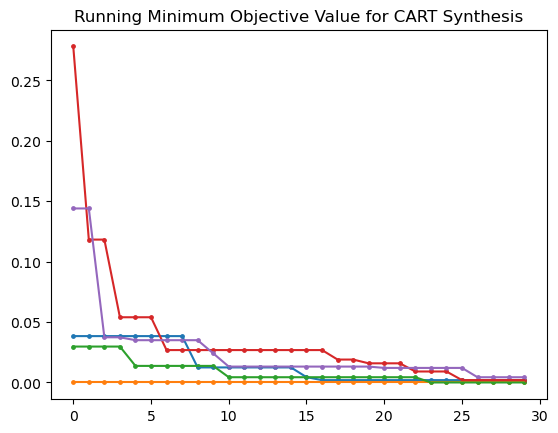

In [10]:
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.plot(run_targets[2])
plt.scatter(np.arange(len(run_targets[2])), run_targets[2], s=6)
plt.plot(run_targets[3])
plt.scatter(np.arange(len(run_targets[3])), run_targets[3], s=6)
plt.plot(run_targets[4])
plt.scatter(np.arange(len(run_targets[4])), run_targets[4], s=6)
plt.title("Running Minimum Objective Value for CART Synthesis")
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [11]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [12]:
best_params

{'target': -8.899172846265437e-06,
 'params': {'ccp_alpha_age_': 0.0007080287595573054,
  'ccp_alpha_sex_': 0.008150640110845311,
  'ccp_alpha_state_': 0.007679049609782695,
  'num_components_': 372.09619260704494}}

***

Generate 1000 synthetic datasets, choose the 20 that have the pMSE closest to 1.

In [13]:
full_ratios, full_sXs, GMM, cart_sex, cart_age, cart_state = train_models(train_data=train_data,
                                                                          number_synthetic_datasets=20,
                                                                          # hyperparameters for GMM
                                                                          number_gmm_initializations=ngi,
                                                                          num_components_=int(best_params['params']['num_components_']),
                                                                          # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                                                                          ccp_alpha_sex_=best_params['params']['ccp_alpha_sex_'],
                                                                          ccp_alpha_age_=best_params['params']['ccp_alpha_age_'],
                                                                          ccp_alpha_state_=best_params['params']['ccp_alpha_state_'])

In [14]:
(1 - np.mean(full_ratios))**2

0.01549986732409348

In [15]:
np.mean(full_ratios)

1.124498463139484

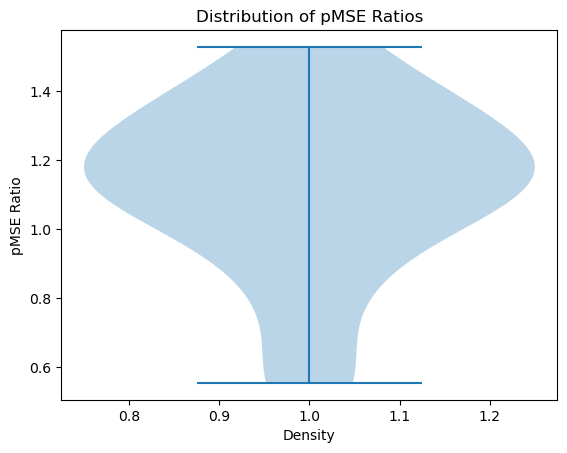

In [16]:
plt.violinplot(full_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

***

# Save the synthetic datasets.

In [17]:
for i, sX in enumerate(full_sXs):
    sX.to_csv("Data/synthetic_datasets/cart_cart_synthetic_dataset_" + str(i) + ".csv", index=False)

***